# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# check if cuda is available
print(torch.cuda.is_available())


print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
from torchvision import datasets

# Define transforms

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(30),
                                     #transforms.RandomResizedCrop(224), # keep it here in case it´s needed later
                                     transforms.ToTensor()]) # if later i want to use a pre trained model, i shouldnt forget to normalize with values used in pretrained model


test_transform = transforms.Compose([#transforms.Resize(224), # keep it here in case it´s needed later
                                      #transforms.CenterCrop(224), # keep it here in case it´s needed later
                                     transforms.ToTensor()])

# Create training set and define training dataloader
data_dir = './data'
trainset = datasets.CIFAR10(data_dir+'/train', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)


# Create test set and define test dataloader
test_set = datasets.CIFAR10(data_dir+'/test', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=True)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

In [5]:
# Explore data - First 
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([5, 3, 32, 32])
torch.Size([5])


In [6]:
# how many images do we have in train set
print (f'There are {len(trainset)} images in the trainset')
print (f'and  there are also {len(test_set)} images in the trainset')

There are 50000 images in the trainset
and  there are also 10000 images in the trainset


horse


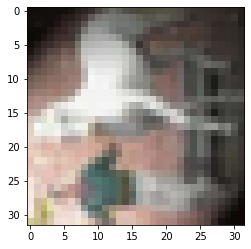

cat


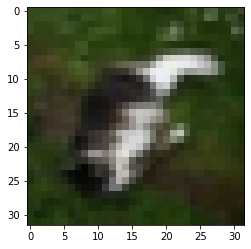

truck


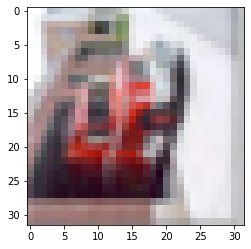

truck


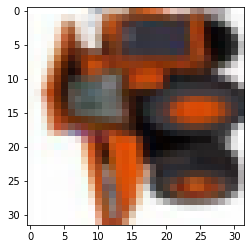

bird


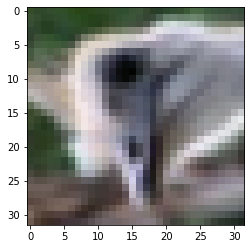

In [7]:
show5(testloader)

car


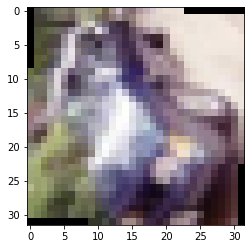

deer


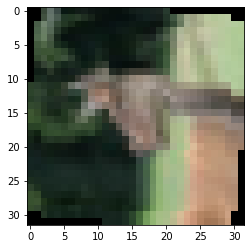

bird


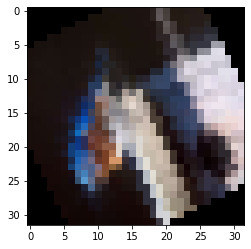

horse


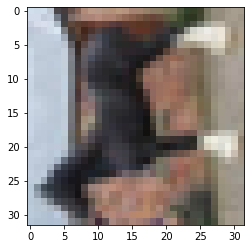

truck


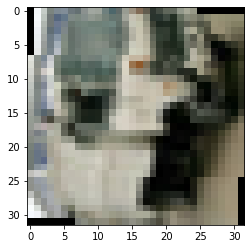

In [8]:
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [9]:
flat_im = images.view(images.shape[0],-1)
flat_im.shape # test length of flattened image

torch.Size([5, 3072])

In [10]:
## YOUR CODE HERE ##
# let´s try first a fully connected layer

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256,64)
        self.fc5 = nn.Linear(64, 10)
        self.drop = nn.Dropout(p=0.2)
  
    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x
    

#### Convolution  -  alternative
The input to a 2D convolution layer must be of size [N,C,H,W] where N is the batch size,
C is the number of channels, H and W are the height and width of the input tensor --> ok with my tensor

syntax
* torch.nn.Conv2d(in_channels, out_channels, kernel_size)

#### Parameters

    in_channels – Number of channels in the input image. (W)
    out_channels – Number of channels produced by the convolution operation. (Output)
    kernel_size – Size of the convolving kernel. (K)
    

Along with the above three parameters, there are some optional parameters also such as stride, padding, dilation, etc.

* stride controls the stride for the cross-correlation, a single number or a tuple. Default is S = 1ves kernel 1 space)

* padding controls the amount of padding applied to the input. It can be either a string {‘valid’, ‘same’} or a tuple of ints giving the amount of implicit padding applied on both sides. Default is P = 0. 

* dilation controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.

#### Calculate output

Output = [(W−K+2P)/S]+1 , but in the end it´s also a choice. 

For each convolutional kernel we use, the output tensor becomes one channel deeper when passing through that layer. If we want a ton of kernels, make this number high, if you want just a few, make this number low. This number will be used in the next convolutional layer. 
Generally, convolutional layers at the front half of a network get deeper and deeper, while fully-connected (aka: linear, or dense) layers at the end of a network get smaller and smaller


    
    https://www.tutorialspoint.com/how-to-apply-a-2d-convolution-operation-in-pytorch
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/
    https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer
    https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd
    https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch
    

In [11]:
#alternative model using convolution

class Convclass(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.drop = nn.Dropout(p=0.2)
        self.conv1 = nn.Conv2d(3,32, 3)  #3 colors in input (R,G,B), output we choose same size as image
        self.conv2 = nn.Conv2d(32,64, 3) # we double the layer
        self.conv3 = nn.Conv2d(64,128, 3) # we double it again
        self.pool = nn.MaxPool2d(2, 2)
        self.fcconv1 = nn.Linear(128*2*2, 256) # final image size comes from calculation using output formula for each step (rounding down)
        self.fcconv2 = nn.Linear(256,64)
        self.fcconv3 = nn.Linear(64,10) # final layer
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.drop(x)
                
        x = x.view(x.shape[0], -1) # flatten image after convolution
        
        x = F.relu(self.fcconv1(x))
        x = self.drop(x)
        x = F.relu(self.fcconv2(x))
        x = F.log_softmax(self.fcconv3(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
## YOUR CODE HERE ##

model = Classifier()
criterion = nn.NLLLoss() # using this because we are using softmax at the end. 
optimizer = optim.Adam(model.parameters(), lr=0.003)




## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [38]:
## YOUR CODE HERE ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()

train_losses, test_losses = [], []

epochs = 3

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        #put gradientsto zero
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        batch_loss = 0 
        
        # Turn off gradients for validation, saves memory and computations
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                log_ps = model(inputs)
                batch_loss += criterion(log_ps, labels)
                
                test_loss += batch_loss.item()
                
                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        model.train()

        print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/1000),
            "Test Loss: {:.3f}.. ".format(test_loss/1000),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/3..  Training Loss: 23.038..  Test Loss: 4609.426..  Test Accuracy: 0.100
Epoch: 2/3..  Training Loss: 23.037..  Test Loss: 4609.993..  Test Accuracy: 0.100
Epoch: 3/3..  Training Loss: 23.037..  Test Loss: 4608.323..  Test Accuracy: 0.100


Plot the training loss (and validation loss/accuracy, if recorded).

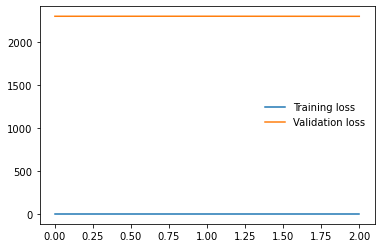

In [40]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Model above doesn#t seem to earn anything????

In [41]:
# second model 

model2 = Convclass()

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

model2.train()

train_losses2, test_losses2 = [], []

epochs = 3

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        #put gradientsto zero
        optimizer.zero_grad()
        
        output = model2.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        batch_loss = 0 
        
        # Turn off gradients for validation, saves memory and computations
        model2.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                log_ps = model(inputs)
                batch_loss += criterion(log_ps, labels)
                
                test_loss += batch_loss.item()
                
                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses2.append(running_loss/len(trainloader))
        test_losses2.append(test_loss/len(testloader))
        
        model2.train()

        print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/1000),
            "Test Loss: {:.3f}.. ".format(test_loss/1000),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/3..  Training Loss: 23.045..  Test Loss: 4608.705..  Test Accuracy: 0.100
Epoch: 2/3..  Training Loss: 23.045..  Test Loss: 4609.389..  Test Accuracy: 0.100
Epoch: 3/3..  Training Loss: 23.045..  Test Loss: 4608.322..  Test Accuracy: 0.100


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

